In [3]:
from torchvision import datasets
from models import Vgg16, AlexNet
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from methods import data_handler
import tensorflow as tf

from copy import deepcopy
import itertools
from PIL import Image

## Load test data

In [28]:
img_folder = datasets.ImageFolder(root=r'C:\Users\julia\Dokumente\GitHub\development\data2\imagenetv2-matched-frequency-format-val')

In [22]:
def sample_random_images(img_folder, number, seed=None):
    images = []
    img_paths = img_folder.imgs.copy()
    if seed:
        random.seed(seed)
    for i in range(number):
        rand_idx = random.randint(0, len(img_paths))
        rand_img_path = img_paths.pop(rand_idx)[0]
        rand_img = img_folder.loader(rand_img_path)
        # resize
        rand_img = rand_img.resize((224, 224))
        # convert to np array
        images.append(np.array(rand_img))
    return np.array(images) / 255

In [23]:
def load_entire_val_set(img_folder):
    """
    So liegen alle Bilder als np array vor; müssen aber als torch-tensor-vorliegen vorliegen
    """
    images = []
    labels_idx = []
    for img_path in tqdm(img_folder.imgs):
        rand_img = img_folder.loader(img_path[0])
        # resize
        rand_img = rand_img.resize((224, 224))
        # convert to np array
        images.append(np.array(rand_img))
        labels_idx.append(int(img_path[0].split("\\")[-2]))
    return np.array(images), np.array(labels_idx)

In [29]:
images, labels_idx = load_entire_val_set(img_folder)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:10<00:00, 140.96it/s]


In [30]:
labels = data_handler.get_labels()

Using downloaded and verified file: .\data/imagenet_class_index.json


## Predict test data

In [119]:
vgg = Vgg16()
alexnet = AlexNet()

Using downloaded and verified file: .\data/imagenet_class_index.json
Using downloaded and verified file: .\data/imagenet_class_index.json


In [36]:
model = tf.keras.applications.VGG16(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

In [89]:
IMG_IDX = 1100

In [90]:
input_preprocessed = tf.keras.applications.vgg16.preprocess_input(images[IMG_IDX].reshape((-1, ) + images[0].shape))

In [91]:
out_idx = model.predict(input_preprocessed).argmax()
out_idx

256

In [92]:
labels[str(out_idx)]

['n02111277', 'Newfoundland']

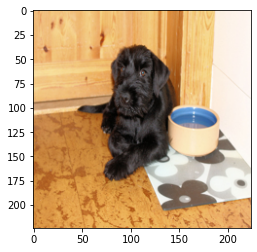

In [93]:
plt.imshow(images[IMG_IDX])

In [115]:
preds = []
labels_idx = []
for img_path in tqdm(img_folder.imgs):
    img = img_folder.loader(img_path[0])
    
    # for PyTorch
#     input_tensor = data_handler.transform()(img)
#     input_tensor = input_tensor.unsqueeze(0)
#     output = model.predict(input_tensor)
#     The output has unnormalized scores. To get probabilities, you can run a softmax on it.
#     probabilities = torch.nn.functional.softmax(output[0], dim=0)
    
    # for tensorflow/keras
    img = img.resize((224, 224), Image.BICUBIC)
    img = np.array(img)
    input_preprocessed = tf.keras.applications.vgg16.preprocess_input(img.reshape((-1, ) + img.shape))
    probabilities = model.predict(input_preprocessed)
    
    labels_idx.append(int(img_path[0].split("\\")[-2]))
    preds.append(probabilities)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [43:22<00:00,  3.84it/s]


## Create statistics

In [ ]:
"""
Anmerkung: finde noch Klassen die sich ähneln heraus

Was kann man für Stats berechnen:
- Pro Klasse Prozent richtig oder falsch
- für falsche Preds: 
    - Berechne Differenz zwischen falscher prob und eigentlich richtiger Prob
        --> um wie viel % lag pred daneben
        --> Könnte bei großer Differenz auch als negativ BSP für Class Confidence gelten
            (ist sowas überhaupt erwünscht; kommt wahrscheinlich darauf an, wie oft solche
            großen Abweichungen vorkommen)
        --> hier sollten generell die Erklärungen besonders schlecht ausfallen
        --> falsche Preds mit hoher Differenz sind besonders für Klassen interessant,
            bei denen ansonsten viel richtig predicted wird (eventuell Clever-Hans)
- für richtige Preds
    - Berechne Differenz zwischen richtiger Pred und nächstgrößter Pred
        --> mögliches Identifizieren schwieriger/ähnlicher Klassen (als schwieriges
        BSP für Conf Scores)
        --> m
- 
"""

In [ ]:
df["pred_conf"] = df.apply(lambda x: x.max(), axis=1)
df["pred_label"] = df[[0:1000]].apply(lambda x: x.argmax(), axis=1)
df["true_label_idx"] = labels_idx
df["pred_is_correct"] = df["pred"] == df["true_label_idx"]

In [131]:
def get_prediction_success_stats_df(preds, labels_idx):
    df = pd.DataFrame(np.array(preds))
    df["pred_conf"] = df[df.columns[0:1000]].apply(lambda x: x.max(), axis=1)
    df["pred_label"] = df[df.columns[0:1000]].apply(lambda x: x.argmax(), axis=1)
    df["true_label_idx"] = labels_idx
    df["pred_is_correct"] = df["pred_label"] == df["true_label_idx"]
    return df

In [120]:
def calc_diff(x):
    # if pred correct, calc confidence differnce to nearest class
    if x["pred_is_correct"]:
        preds = x[0:1000].sort_values(ascending=False)
        return preds[0] - preds[1]
    # else calc confidence difference between predicted class and true class
    conf_true_class = x[x["true_label_idx"]]
    return x[0:1000].max() - conf_true_class

In [121]:
def get_class_grouped_success_stats_df(df_stats):
    # calc accuracy per class
    df_class_grp = df_stats.groupby(by="true_label_idx")["pred_is_correct"].sum() / 10
    # calc mean accuracies per class and pred_is_correct
    # df_vgg_mean_conf = df_stats.groupby(by=["true_label_idx", "pred_is_correct"])["pred_conf"].mean().to_frame()
    return df_class_grp

In [126]:
a = [pred[0] for pred in preds ]

In [130]:
np.array(a).shape

(10000, 1000)

In [133]:
df = get_prediction_success_stats_df(a, labels_idx)
df.to_pickle("./data2/stats/df_vgg_tf.pickle")

In [136]:
df

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,pred_conf,pred_label,true_label_idx,pred_is_correct
0,9.999856e-01,1.356569e-09,3.702469e-13,5.917748e-13,2.367236e-13,3.005052e-11,1.415263e-12,9.601491e-14,1.902951e-13,1.025759e-17,...,2.321329e-10,1.039433e-12,3.450150e-11,2.755729e-08,8.847684e-11,3.615563e-17,0.999986,0,0,True
1,6.308938e-01,9.298315e-05,2.759929e-05,9.062310e-05,8.046998e-05,2.878932e-04,3.858765e-04,2.311315e-04,3.998122e-04,4.643457e-05,...,4.374837e-04,1.447227e-04,1.446205e-03,6.264140e-04,7.235371e-04,3.509840e-06,0.630894,0,0,True
2,9.325095e-01,7.793210e-06,4.034938e-07,1.587415e-07,2.498825e-06,1.690587e-07,4.347047e-07,5.886855e-08,1.912144e-08,5.016987e-10,...,3.197122e-06,4.366819e-08,1.198621e-06,3.467664e-06,4.541460e-07,1.221400e-09,0.932510,0,0,True
3,9.958712e-01,9.964630e-07,1.370963e-07,4.990717e-08,4.326203e-07,8.119130e-07,1.748887e-06,9.951932e-09,9.177461e-08,1.107706e-10,...,2.436106e-07,3.439266e-07,2.771916e-07,5.985844e-05,1.194054e-06,4.513439e-10,0.995871,0,0,True
4,7.659267e-01,5.358352e-04,1.256794e-05,7.070900e-05,9.560698e-05,7.014071e-04,1.264581e-03,2.964319e-06,6.581758e-07,2.664214e-08,...,5.811697e-06,2.795064e-06,1.881744e-05,1.542850e-04,9.559457e-05,2.589282e-07,0.765927,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6.524381e-06,5.275378e-06,1.518953e-05,1.111131e-06,1.463350e-06,1.621142e-06,3.233524e-07,3.852628e-06,2.064853e-06,2.114032e-06,...,1.514477e-06,2.079776e-06,6.112447e-06,6.197573e-07,1.315228e-05,6.664968e-02,0.121508,886,999,False
9996,1.615363e-07,2.573839e-06,9.581174e-06,7.023561e-06,8.509995e-05,5.073565e-06,5.371518e-06,4.258919e-05,4.367532e-05,3.450399e-07,...,1.763868e-07,4.409575e-06,4.643568e-07,5.096637e-07,5.770638e-05,9.339843e-02,0.219738,151,999,False
9997,2.662673e-07,3.230835e-07,2.562766e-07,2.784524e-07,1.531026e-07,1.136288e-07,1.526312e-07,2.858109e-07,2.481868e-07,7.415211e-08,...,3.250165e-05,9.913057e-08,6.603429e-07,1.012010e-07,3.119678e-06,6.343130e-02,0.484971,496,999,False
9998,1.217091e-04,5.273312e-04,3.572998e-03,8.856595e-04,3.153571e-03,2.873073e-04,3.184296e-04,4.070757e-04,4.274237e-04,2.829960e-06,...,3.001768e-04,8.996005e-05,2.962732e-04,3.937375e-05,1.369411e-03,9.305154e-02,0.093052,999,999,True


In [137]:
df["pred_is_correct"].sum() / df.shape[0]

0.5196

In [138]:
df_vgg["pred_is_correct"].sum() / df_vgg.shape[0]

0.5322

### Vgg stats

In [2]:
df_vgg = pd.read_pickle("./data2/stats/df_vgg.pickle")

In [3]:
# nachträglich berechnen
# df_vgg["conf_diff"] = df_vgg.apply(calc_diff, axis=1) # bis jetzt nicht mit anzufangen
df_vgg["pred_conf"] = df_vgg.apply(lambda x: x[0:1000].max(), axis=1)

In [4]:
# overall accuray:
df_vgg["pred_is_correct"].sum() / 10000

0.5322

In [9]:
df_vgg_grp = get_class_grouped_success_stats_df(df_vgg)

In [10]:
df_vgg_grp

true_label_idx
0      0.9
1      0.8
2      0.5
3      0.3
4      0.6
      ... 
995    1.0
996    0.8
997    0.4
998    0.7
999    0.3
Name: pred_is_correct, Length: 1000, dtype: float64

<AxesSubplot:xlabel='true_label_idx'>

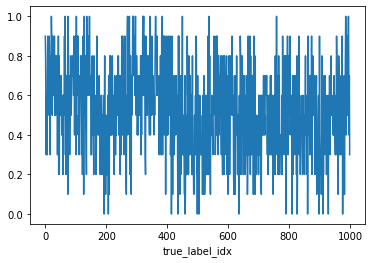

In [11]:
df_vgg_grp.plot()

In [12]:
df_vgg_frac_correct = df_vgg_grp.value_counts(normalize=False).sort_index().to_frame("fraction_correct").reset_index()
df_vgg_frac_correct.columns = ["accuracy", "number classes"]

In [13]:
df_vgg_frac_correct

,accuracy,number classes
0,0.0,16
1,0.1,30
2,0.2,70
3,0.3,111
4,0.4,133
5,0.5,165
6,0.6,154
7,0.7,139
8,0.8,95
9,0.9,65


In [17]:
# print unsuccessful classes
for idx in df_vgg_grp[df_vgg_grp == 0.0].index:
    print(labels[str(idx)][1])

Australian_terrier
golden_retriever
backpack
bathtub
brassiere
cleaver
coffeepot
magnetic_compass
shopping_basket
space_bar
stove
toilet_seat
water_bottle
wool
ice_lolly
promontory


In [18]:
# print successful classes
for idx in df_vgg_grp[df_vgg_grp == 1.0].index:
    print(labels[str(idx)][1])

water_ouzel
sea_snake
black_widow
echidna
black_stork
European_gallinule
king_penguin
white_wolf
hyena
lynx
snow_leopard
ice_bear
damselfly
monarch
warthog
badger
indri
bobsled
dogsled
reflex_camera
yellow_lady's_slipper
earthstar


### Alex stats

In [3]:
df_alex = pd.read_pickle("./data2/stats/df_alexnet.pickle")

In [30]:
# nachträglich berechnen
# df_vgg["conf_diff"] = df_vgg.apply(calc_diff, axis=1) # bis jetzt nicht mit anzufangen
df_alex["pred_conf"] = df_alex.apply(lambda x: x[0:1000].max(), axis=1)

In [31]:
# overall accuray:
df_alex["pred_is_correct"].sum() / 10000

0.347

In [32]:
df_alex_grp = get_class_grouped_success_stats_df(df_alex)

In [33]:
df_alex_grp

true_label_idx
0      0.7
1      0.7
2      0.4
3      0.2
4      0.2
      ... 
995    0.9
996    0.8
997    0.3
998    0.3
999    0.1
Name: pred_is_correct, Length: 1000, dtype: float64

<AxesSubplot:xlabel='true_label_idx'>

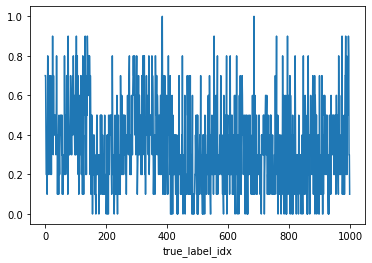

In [34]:
df_alex_grp.plot()

In [39]:
df_alex_frac_correct = df_alex_grp.value_counts(normalize=False).sort_index().to_frame("fraction_correct").reset_index()
df_alex_frac_correct.columns = ["accuracy", "number classes"]

In [40]:
df_alex_frac_correct

,accuracy,number classes
0,0.0,63
1,0.1,134
2,0.2,177
3,0.3,170
4,0.4,148
5,0.5,134
6,0.6,72
7,0.7,53
8,0.8,36
9,0.9,11


In [41]:
# print unsuccessful classes
for idx in df_alex_grp[df_alex_grp == 0.0].index:
    print(labels[str(idx)][1])

Shih-Tzu
Walker_hound
Saluki
Tibetan_terrier
Lhasa
golden_retriever
briard
miniature_pinscher
apron
ashcan
backpack
ballpoint
bathing_cap
bathtub
bonnet
brassiere
cassette
catamaran
cellular_telephone
chain
cleaver
cloak
clog
cradle
crash_helmet
crate
crutch
drumstick
dumbbell
hair_spray
hatchet
letter_opener
Loafer
magnetic_compass
minivan
modem
monitor
moped
pencil_box
piggy_bank
rifle
sandal
screwdriver
shopping_basket
shovel
soap_dispenser
space_bar
spatula
stole
studio_couch
swab
syringe
toaster
toilet_seat
tray
velvet
waffle_iron
water_bottle
water_jug
wooden_spoon
wool
ice_lolly
bagel


In [42]:
# print successful classes
for idx in df_alex_grp[df_alex_grp == 1.0].index:
    print(labels[str(idx)][1])

indri
odometer


### Analyze similarities and differences

In [54]:
df_diff = (df_vgg_grp - df_alex_grp)

<AxesSubplot:title={'center':'VGG16 vs. AlexNet on all classes'}, xlabel='class_index', ylabel='accuracy_vgg - accuracy-alex'>

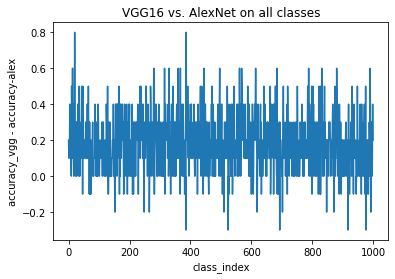

In [55]:
df_diff.plot(xlabel="class_index", ylabel="accuracy_vgg - accuracy-alex", title="VGG16 vs. AlexNet on all classes")

In [69]:
df_diff.sort_values().head(5)

true_label_idx
693   -0.3
524   -0.3
976   -0.3
917   -0.3
385   -0.3
Name: pred_is_correct, dtype: float64

In [70]:
df_diff.sort_values().tail(5)

true_label_idx
561    0.6
496    0.6
315    0.6
20     0.8
386    0.8
Name: pred_is_correct, dtype: float64

In [67]:
num = 5
for i in range(num):
    print(labels[str(df_diff.sort_values().head(5).index[i])][1])

paddle
cuirass
promontory
comic_book
Indian_elephant


In [68]:
num = 5
for i in range(num):
    print(labels[str(df_diff.sort_values().tail(5).index[i])][1])

forklift
Christmas_stocking
mantis
water_ouzel
African_elephant


## Create experiment sheets

### Generate dataset according to 50:50 model & 50:50 successrate restrictions

In [2]:
NUM_EXP_SHEETS = 5
NUM_IMGS_PER_SHEET = 48 # Requires: (NUM_IMGS_PER_SHEET/2) mod NUM_XAI_METHODS = 0

NUM_IMGS = NUM_IMGS_PER_SHEET/2 + NUM_EXP_SHEETS*(NUM_IMGS_PER_SHEET/2) # min num of pictures that need to be drawn

In [3]:
def generate_img_pool(NUM_IMGS, df_alex, df_vgg, seed=None):
    """ 
    Generates the four output lists alex_success, alex_no_success, 
    vgg_success and vgg_no_success that each contain image indixes that
    fit the lists name description.
    All lists will be contain equally many image indizes.
    
    If the argument 'seed' isn't passed in, no seed is set.

    Parameters
    ----------
    NUM_IMGS : Number of images the four output lists will contain in tota:
        The sound the animal makes (default is None)
    
    Returns
    ------
    The four output lists alex_success, alex_no_success, 
    vgg_success and vgg_no_success
    """
    if seed:
        random.seed(seed)
        
    alex_success, alex_no_success = [], []
    vgg_success, vgg_no_success = [], []

    img_indexes = list(range(0, df_alex.shape[0]))
    img_paths = img_folder.samples
    length_of_all_lists = len(alex_success) + len(alex_no_success) + len(vgg_success) + len(vgg_no_success)

    while length_of_all_lists < NUM_IMGS:
        rand_img_idx = img_indexes.pop(random.randint(0, len(img_indexes)-1))
        rand_img_path = img_paths[rand_img_idx]

    # currently not needed as .pop() is used
    #     if rand_img_idx in "einer der Listen":
    #         continue

    # currently not needed as predictions are already saved in pickled dataframes
    #     pred_alex = alex.predict(img)
    #     pred_vgg = vgg.predict(img)

        if (df_alex["pred_is_correct"][rand_img_idx]) and (len(alex_success) < NUM_IMGS/4):
            alex_success.append(rand_img_idx)
        elif (not df_alex["pred_is_correct"][rand_img_idx]) and (len(alex_no_success) < NUM_IMGS/4):
            alex_no_success.append(rand_img_idx)
        elif (df_vgg["pred_is_correct"][rand_img_idx]) and (len(vgg_success) < NUM_IMGS/4):
            vgg_success.append(rand_img_idx)
        elif (not df_vgg["pred_is_correct"][rand_img_idx]) and (len(vgg_no_success) < NUM_IMGS/4):
            vgg_no_success.append(rand_img_idx)
        
        length_of_all_lists = len(alex_success) + len(alex_no_success) + len(vgg_success) + len(vgg_no_success)
    
    return alex_success, alex_no_success, vgg_success, vgg_no_success

In [4]:
alex_success, alex_no_success, vgg_success, vgg_no_success = generate_img_pool(NUM_IMGS, df_alex, df_vgg, seed=None)

NameError: name 'img_folder' is not defined

In [261]:
img_pool = [alex_success, alex_no_success, vgg_success, vgg_no_success] 

In [262]:
np.array(img_pool).shape

(4, 36)

In [263]:
# show class_idx distribution of alex_success
# df_alex["true_label_idx"][alex_success].value_counts()

### Generation of experiment sheets

In [264]:
# Generierung von e_fixed
# len(e_fixed) muss NUM_IMGS_PER_SHEET/2 sein und durch 6 teilbar sein (z. B. 24/2=12 und 12 mod 6=0)
# ziehe aus jeder subliste NUM_IMGS_PER_SHEET/(2*4) Fotos (z. B. 24/8=3 Fotos) bzw. (48/8=6 Fotos)
# --> kacke; eigentlich bräuchten wir am besten 6 Fotos, um für jede XAI-Methode eines zu haben
# --> bräuchten dann mindestens NUM_IMGS_PER_SHEET=48 (sind das zuviele?)
# --> Sinnfrage klären
# wende auf zufällige Bilder zufällige XAI an.

In [265]:
def get_half_exp_sheet(NUM_IMGS_PER_SHEET, img_pool, xai_methods):
    
    half_exp_sheet = []
    for img_selection in img_pool:
        for i in range(int(NUM_IMGS_PER_SHEET / (2 * len(img_pool)))):
            img_idx = img_selection.pop(random.randint(0, len(img_selection)-1))
            question = (img_idx, xai_methods[i])
            half_exp_sheet.append(question)
            
    return half_exp_sheet

In [266]:
def generate_experiment_sheets(NUM_EXP_SHEETS, NUM_IMGS_PER_SHEET, img_pool):
    
    exp_sheets_list = []
    img_pool_cpy = deepcopy(img_pool)
    xai_methods = ["gradCam", "LRP", "SHAP", "LIME", "ConfidenceScores", "CEM"]
    
    exp_sheet_fixed = get_half_exp_sheet(NUM_IMGS_PER_SHEET, img_pool_cpy, xai_methods)
    for i in range(NUM_EXP_SHEETS):
        experiment_sheet = exp_sheet_fixed.copy()
        experiment_sheet += get_half_exp_sheet(NUM_IMGS_PER_SHEET, img_pool_cpy, xai_methods)
        exp_sheets_list.append(experiment_sheet)
    
    return exp_sheets_list

In [267]:
exp_sheets_list = generate_experiment_sheets(NUM_EXP_SHEETS, NUM_IMGS_PER_SHEET, img_pool)

# Picking  procedure as proposed by Christian

In [2]:
imgs_idx = list(range(10000))
xai_methods = ['gradCam', 'LRP', 'SHAP', 'LIME', 'ConfidenceScores', 'CEM']
models = ["alex", "vgg"]

df_vgg = pd.read_pickle("./data2/stats/df_vgg.pickle")
df_alex = pd.read_pickle("./data2/stats/df_alexnet.pickle")

NameError: name 'pd' is not defined

In [8]:
def get_fixed_img_questionaires(imgs_idx, xai_methods, models):
    
    NUM_QUESTIONAIRES = 12
    NUM_IMGS = 12
    questionaires_list = []
    random_imgs_idx = [imgs_idx.pop(random.randint(0, len(imgs_idx)-1)) for i in range(NUM_IMGS)]
    permutations = list(itertools.product(random_imgs_idx, models, xai_methods))
    # distribute permutations on questionaires 
    for q in range(NUM_QUESTIONAIRES):
        questionaire = []
        for i in range(NUM_IMGS):
            if (q+i) > (NUM_IMGS-1):
                questionaire.append(permutations[i*NUM_IMGS:i*NUM_IMGS+NUM_IMGS][(q+i) - NUM_IMGS])
            else:
                questionaire.append(permutations[i*NUM_IMGS:i*NUM_IMGS+NUM_IMGS][q+i])
        questionaires_list.append(questionaire)
    
    return questionaires_list

In [9]:
questionaires_list = get_fixed_img_questionaires(imgs_idx, xai_methods, models)

In [10]:
questionaires_list[0]

[(2367, 'alex', 'gradCam'),
 (6002, 'alex', 'LRP'),
 (1240, 'alex', 'SHAP'),
 (7240, 'alex', 'LIME'),
 (5790, 'alex', 'ConfidenceScores'),
 (716, 'alex', 'CEM'),
 (5417, 'vgg', 'gradCam'),
 (9640, 'vgg', 'LRP'),
 (1665, 'vgg', 'SHAP'),
 (3438, 'vgg', 'LIME'),
 (3690, 'vgg', 'ConfidenceScores'),
 (5331, 'vgg', 'CEM')]

In [11]:
questionaires_list[1]

[(2367, 'alex', 'LRP'),
 (6002, 'alex', 'SHAP'),
 (1240, 'alex', 'LIME'),
 (7240, 'alex', 'ConfidenceScores'),
 (5790, 'alex', 'CEM'),
 (716, 'vgg', 'gradCam'),
 (5417, 'vgg', 'LRP'),
 (9640, 'vgg', 'SHAP'),
 (1665, 'vgg', 'LIME'),
 (3438, 'vgg', 'ConfidenceScores'),
 (3690, 'vgg', 'CEM'),
 (5331, 'alex', 'gradCam')]

In [12]:
questionaires_list[5]

[(2367, 'alex', 'CEM'),
 (6002, 'vgg', 'gradCam'),
 (1240, 'vgg', 'LRP'),
 (7240, 'vgg', 'SHAP'),
 (5790, 'vgg', 'LIME'),
 (716, 'vgg', 'ConfidenceScores'),
 (5417, 'vgg', 'CEM'),
 (9640, 'alex', 'gradCam'),
 (1665, 'alex', 'LRP'),
 (3438, 'alex', 'SHAP'),
 (3690, 'alex', 'LIME'),
 (5331, 'alex', 'ConfidenceScores')]

In [13]:
def add_random_unique_images(questionaires_list, imgs_idx, df_alex, df_vgg, xai_methods):
   
    FINAL_QUESTIONAIRE_SIZE = 24
    
    for idx_qn, questionaire in enumerate(questionaires_list):
        
        df_variants_count = pd.DataFrame(list(itertools.product(xai_methods, models, [True, False]))).groupby([0, 1, 2]).count()
        df_variants_count["count"] = 0
        
        # evaluate variants for the already drawn fixed questions
        for idx_q, question in enumerate(questionaire):
            if question[1] == "alex":
                if df_alex["pred_is_correct"][question[0]]:
                    questionaires_list[idx_qn][idx_q] += (True, )
                    df_variants_count.loc[question[2], "alex", True]["count"] += 1
                else: 
                    questionaires_list[idx_qn][idx_q] += (False, )
                    df_variants_count.loc[question[2], "alex", False]["count"] += 1
            else:
                if df_vgg["pred_is_correct"][question[0]]:
                    questionaires_list[idx_qn][idx_q] += (True, )
                    df_variants_count.loc[question[2], "vgg", True]["count"] += 1
                else:
                    questionaires_list[idx_qn][idx_q] += (False, )
                    df_variants_count.loc[question[2], "vgg", False]["count"] += 1
                    
        # add addtional random images to each questionaire such that for every variant in df_variants_count the 
        # count will be 1
        while df_variants_count["count"].sum() != FINAL_QUESTIONAIRE_SIZE:
            rand_img_idx = imgs_idx.pop(random.randint(0, len(imgs_idx)-1))
            
            alex_pred = df_alex.loc[rand_img_idx]["pred_is_correct"]
            vgg_pred = df_alex.loc[rand_img_idx]["pred_is_correct"]
            
            df_alex_options = df_variants_count.loc[:, "alex", alex_pred]
            df_alex_options = df_alex_options[df_alex_options["count"] == 0]
            
            df_vgg_options = df_variants_count.loc[:, "vgg", vgg_pred]
            df_vgg_options = df_vgg_options[df_vgg_options["count"] == 0]
            
            if not df_alex_options.empty:
                rand_variant = df_alex_options.index[random.randint(0, df_alex_options.shape[0]-1)]
                question = (rand_img_idx, rand_variant[1], rand_variant[0], rand_variant[2])
                questionaire.append(question)
                df_variants_count.loc[rand_variant]["count"] += 1
            
            elif not df_vgg_options.empty:
                rand_variant = df_vgg_options.index[random.randint(0, df_vgg_options.shape[0]-1)]
                question = (rand_img_idx, rand_variant[1], rand_variant[0], rand_variant[2])
                questionaire.append(question)
                df_variants_count.loc[rand_variant]["count"] += 1
                    
    return df_variants_count

In [14]:
df_test = add_random_unique_images(questionaires_list, imgs_idx, df_alex, df_vgg, xai_methods)

In [15]:
df_qn1 = pd.DataFrame(questionaires_list[0])

In [16]:
df_qn1

,0,1,2,3
0,2367,alex,gradCam,False
1,6002,alex,LRP,False
2,1240,alex,SHAP,False
3,7240,alex,LIME,False
4,5790,alex,ConfidenceScores,False
5,716,alex,CEM,False
6,5417,vgg,gradCam,True
7,9640,vgg,LRP,False
8,1665,vgg,SHAP,False
9,3438,vgg,LIME,False


In [19]:
df_qn1.groupby(by=[2,1,3]).count()

0
2                1    3       
CEM              alex False  1
                      True   1
                 vgg  False  1
                      True   1
ConfidenceScores alex False  1
                      True   1
                 vgg  False  1
                      True   1
LIME             alex False  1
                      True   1
                 vgg  False  1
                      True   1
LRP              alex False  1
                      True   1
                 vgg  False  1
                      True   1
SHAP             alex False  1
                      True   1
                 vgg  False  1
                      True   1
gradCam          alex False  1
                      True   1
                 vgg  False  1
                      True   1

In [1]:
questionaires_list

NameError: name 'questionaires_list' is not defined